In [41]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import brewer2mpl
from mitgcmdata import MITgcmmodel
from jmd95 import eos
import datetime

%matplotlib inline
plt.rcParams['image.origin'] = 'bottom'
plt.rcParams['figure.figsize'] = (16,8)


bmap = brewer2mpl.get_map('Set1', 'Qualitative', 6)
plt.rcParams['axes.color_cycle'] = bmap.mpl_colors


In [11]:
#ddir = '/glade/scratch/rpa/SOSE/run_matt'
#ddir = '/data/scratch/rpa/SOSE/run_matt'
ddir = '/data/scratch/rpa/SOSE/run_np240'

m = MITgcmmodel.ModelInstance(output_dir=ddir)


/data/scratch/rpa/SOSE/run_np240/XC.meta
/data/scratch/rpa/SOSE/run_np240/XG.meta
/data/scratch/rpa/SOSE/run_np240/YC.meta
/data/scratch/rpa/SOSE/run_np240/YG.meta
/data/scratch/rpa/SOSE/run_np240/DYC.meta
/data/scratch/rpa/SOSE/run_np240/DYG.meta
/data/scratch/rpa/SOSE/run_np240/DXC.meta
/data/scratch/rpa/SOSE/run_np240/DXG.meta
/data/scratch/rpa/SOSE/run_np240/RAC.meta
/data/scratch/rpa/SOSE/run_np240/RC.meta
/data/scratch/rpa/SOSE/run_np240/RF.meta
/data/scratch/rpa/SOSE/run_np240/DRC.meta
/data/scratch/rpa/SOSE/run_np240/DRF.meta
/data/scratch/rpa/SOSE/run_np240/Depth.meta
/data/scratch/rpa/SOSE/run_np240/hFacC.meta
/data/scratch/rpa/SOSE/run_np240/hFacS.meta


2160 320  42


/data/scratch/rpa/SOSE/run_np240/hFacW.meta



    frequency(1) =  432000.0,
    fields(1,1) = 'SIarea  ','SIheff  ','SIhsnow ','SItflux ',
                 'SIatmQnt','SIempmr ','SIatmFW ','SIuheff ',
                 'SIvheff ','TFLUX   ','SFLUX   ','THETA   ',
                 'SALT    ','WTHMASS ','WSLTMASS','SIuice  ',
                 'SIvice  ','SIsnPrcp',
                 'SIdHbOCN','SIdSbOCN','SIdHbATO',
    levels(1,1) = 1,
    filename(1) = 'DiagIce-5day',


In [4]:
deltaT = 900
#diag_freq = 2629200. # monthly
#diag_prefix = 'DiagIce-monthly'

diag_freq = 432000 # 5-day
diag_prefix= 'DiagIce-5day'

diag_delta_iter = diag_freq/deltaT

ntimesteps = 210336
diag_iters = np.round(np.arange(diag_delta_iter, ntimesteps+1, diag_delta_iter)).astype('i4')
Nt = len(diag_iters)

diag_names = ['SIarea', 'SIheff', 'SIhsnow', 'SItflux', 'SIatmQnt', 'SIempmr',
             'SIatmFW', 'SIuheff', 'SIvheff', 'TFLUX', 'SFLUX', 'THETA', 'SALT',
             'WTHMASS','WSLTMASS','SIuice','SIvice','SIsnPrcp',
             'SIdHbOCN','SIdSbOCN','SIdHbATO']



In [5]:
lon = m.xc[0,:,:]
lat = m.yc[0,:,:]

In [6]:
def surface_transformation_rate(m, rho, rholevs, *args):
    """Calculate surface transformation rate given
        m: an MITgcmmodel.ModelInstance
        rho: a surface density field
        rholevs: density levels (to define bins)
        args: various components of the density flux
    """

    drho = np.diff(rholevs)
    Nbins = len(rholevs)-1
    
    # mask anything outside the range
    rho_m = np.ma.masked_greater_equal(
                np.ma.masked_less(rho, rholevs.min()), rholevs.max())
    mask = rho_m.mask
    
    rho_idx = np.digitize(rho_m.compressed(), rholevs)-1
    assert rho_idx.min()>=0
    assert rho_idx.max()<=Nbins
        
    # rho_idx==i means rholevs[i-1] <= rholevs < rholevs[i]
    
    
    res = []
    for a in args:
        dens_flux = np.ma.masked_array(a * m.rac, mask)
        res.append(
            np.bincount(rho_idx, weights=dens_flux.compressed(), minlength=Nbins)
            / drho
        )
    return np.array(res)
    
    

In [139]:
def average_field_in_rho(m, rho, rholevs, a, avg=True):
    """Calculate surface transformation rate given
        m: an MITgcmmodel.ModelInstance
        rho: a surface density field
        rholevs: density levels (to define bins)
        args: various components of the density flux
    """

    drho = np.diff(rholevs)
    Nbins = len(rholevs)-1
    
    # mask anything outside the range
    rho_m = np.ma.masked_greater_equal(
                np.ma.masked_less(rho, rholevs.min()), rholevs.max())
    mask = rho_m.mask
    
    rho_idx = np.digitize(rho_m.compressed(), rholevs)-1
    assert rho_idx.min()>=0
    assert rho_idx.max()<=Nbins
        
    # rho_idx==i means rholevs[i-1] <= rholevs < rholevs[i]
    
        
    rac_masked = np.ma.masked_array(m.rac, mask)
    area = np.bincount(rho_idx, weights=rac_masked.compressed(), minlength=Nbins)
    area_recip = np.where(area>0., area**-1, 0.)

    # area-weighted average
    res = np.bincount(rho_idx, weights=(a*rac_masked).compressed(), minlength=Nbins)
    if avg:
        res *= area_recip
    return res, area
    

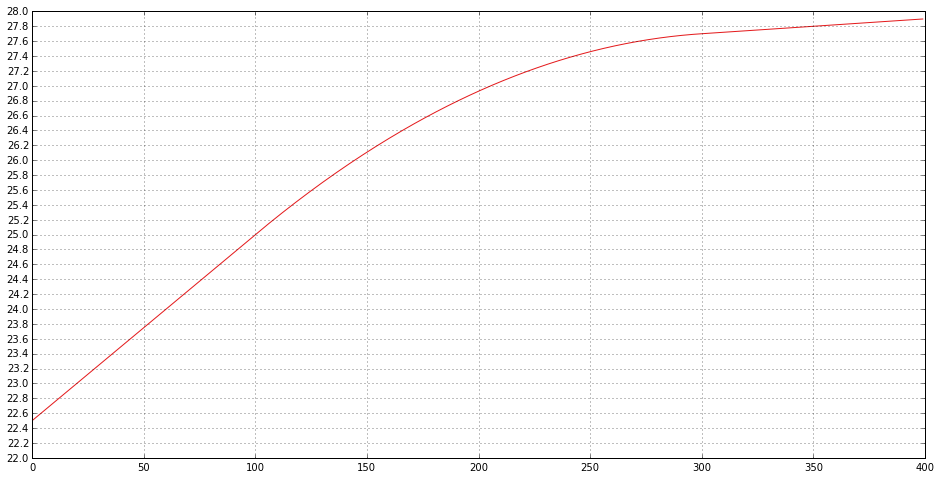

In [7]:
drho1 = 0.002
drho2 = 0.025
#drho3 = 0.025

rho0 = 1027.9

drho = np.hstack([
        drho1 * np.ones(100),
        np.linspace(drho1, drho2, 200),
        drho2 * np.ones(100),
#        np.linspace(drho2, drho3 ,100),
#        drho3 * np.ones(100),
])
rholevs = (rho0 - np.cumsum(drho))[::-1]
plt.plot(rholevs-1000, '-')
plt.yticks(np.arange(22,28.1,0.2))
plt.grid()

In [8]:
salt_EvPrRn=0.
rUnit2mass=1.035E+03
HeatCapacity_Cp=3.994E+03

fluxfac_T = 1.0/(HeatCapacity_Cp*rUnit2mass)
fluxfac_S = 1.0/rUnit2mass

# gives m/year
scalefac = 24*60*60*365/1e3

#Nrho = 300
#rholevs = np.linspace(1022.,1028.0,Nrho+1)

Nrho = len(rholevs)-1

kg_fw_to_m = 1e-3
m_to_kg_fw = 1e3

fw_flux_types = ['IO_plus_AO', 'AI_plus_AO', 'AI', 'AO', 'IO', 'IO_brine', 'IO_melt']

fld_idx = dict()
for n, k in enumerate(fw_flux_types):
    fld_idx[k] = n


In [16]:
d['WTHMASS'].shape

(320, 2160)

In [140]:
# density-weighted ice concentration
ice_conc_rho = np.zeros((Nt, Nrho), 'f8')
heff_rho = np.zeros((Nt, Nrho), 'f8')
outcrop_area = np.zeros((Nt, Nrho), 'f8')
for nmon, niter in enumerate(diag_iters):
    
    #SIarea = m.rdmds(diag_prefix, niter, rec=0)
    heff = m.rdmds(diag_prefix, niter, rec=1)
    theta = m.rdmds(diag_prefix, niter, rec=11)
    salt = m.rdmds(diag_prefix, niter, rec=12)
    
    rho, drhodt, drhods = eos.state_surface(theta, salt)
    
    #ice_conc_rho[nmon], outcrop_area[nmon] = average_field_in_rho(m, rho, rholevs, SIarea)
    heff_rho[nmon], outcrop_area[nmon] = average_field_in_rho(m, rho, rholevs, heff, avg=False)
    

/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000000480.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000000480.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000000480.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000000960.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000000960.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000000960.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000001440.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000001440.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000001440.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000001920.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000001920.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000001920.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000002400.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000002400.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000002400.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000002880.meta
/data/sc

In [13]:
transformation = np.zeros((Nt, len(fw_flux_types)+3, Nrho), 'f8')
fw_in_dens_coords = np.zeros((Nt, len(fw_flux_types), Nrho), 'f8')

for nmon, niter in enumerate(diag_iters):
    
    draw = m.rdmds(diag_prefix, niter)
    d = {}
    for n, dn in enumerate(diag_names):
        d[dn] = draw[n]
        
    rho, drhodt, drhods = eos.state_surface(d['THETA'], d['SALT'])

    # freshwater fluxes, evaporation positive
    fw_fluxes = {
      'IO_plus_AO': np.ma.masked_array(d['SIempmr'], m.mask[0]),
      'AI_plus_AO': -np.ma.masked_array(d['SIatmFW'], m.mask[0]),
# ------ not actually useful ----------
#       'SIdHbOCN': -m_to_kg_fw * np.ma.masked_array(data['SIdHbOCN'][season], m.mask[0]),
#       'SIdSbOCN': -m_to_kg_fw * np.ma.masked_array(data['SIdSbOCN'][season], m.mask[0]),
#       'SIdHbATO': -m_to_kg_fw * np.ma.masked_array(data['SIdSbOCN'][season], m.mask[0]),
      'SIsnPrcp':  -np.ma.masked_array(d['SIsnPrcp'], m.mask[0])
    }
    
    fw_fluxes['AI'] = fw_fluxes['SIsnPrcp']
    fw_fluxes['AO'] = fw_fluxes['AI_plus_AO'] - fw_fluxes['AI']
    fw_fluxes['IO'] = fw_fluxes['IO_plus_AO'] - fw_fluxes['AO']
    # brine rejection
    fw_fluxes['IO_brine'] = np.ma.masked_less(fw_fluxes['IO'].copy(), 0.)
    fw_fluxes['IO_melt'] = np.ma.masked_greater(fw_fluxes['IO'].copy(), 0.)
    
    # has the same units as SFLUX
    salt = d['SALT']
    
    dens_flux_S = [ drhods * fluxfac_S * fw_fluxes[k].filled(0.) * (salt - salt_EvPrRn)
                    for k in fw_flux_types ]

    dens_flux_S.append( drhods * d['WSLTMASS'] )
    
    fw_flux = [fw_fluxes[k].filled(0.) for k in fw_flux_types]
    
    tflux = np.ma.masked_array(d['TFLUX'], m.mask[0]) 
    dens_flux_T = [drhodt * fluxfac_T * tflux, ]
    
    dens_flux_T.append( drhodt * d['WTHMASS'])
    
    transformation[nmon] = surface_transformation_rate(
                        m, rho, rholevs,
                         *(dens_flux_T + dens_flux_S))
    
    fw_in_dens_coords[nmon] = surface_transformation_rate(
                        m, rho, rholevs, *fw_flux)

    

/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000000480.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000000960.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000001440.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000001920.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000002400.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000002880.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000003360.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000003840.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000004320.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000004800.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000005280.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000005760.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000006240.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000006720.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000007200.meta
/data/scratch/rpa/SOSE/run_np240/DiagIce-5day.0000007680.meta
/data/sc

In [52]:
# load extra water mass transformation data
wmt_full = np.load('../data/wmt_upper_470m.npz')
labels_salt = ['surfflux', 'linfs', 'adv', 'hdiff', 'kpp', 'tot', 'vdiff']
labels_heat = ['surfflux', 'linfs', 'adv', 'kpp', 'vdiff', 'sw', 'tot', 'hdiff']
wmt_salt = wmt_full['wmt_salt'] 
wmt_heat = wmt_full['wmt_heat'] 
wmt_salt_mean = wmt_salt.mean(axis=0)
wmt_heat_mean = wmt_heat.mean(axis=0)


# Transformation Rates #

In [12]:
#transformation_run_matt = transformation.copy()

In [151]:
wmass_names = {'SAMW': 26.0, 'AAIW': 27.0, 'UCDW': 27.55, 'LCDW': 27.72, 'AABW': 27.82}

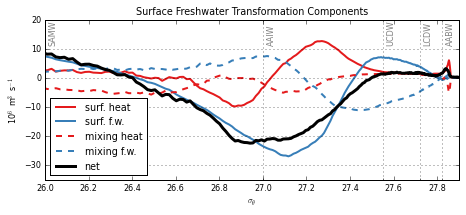

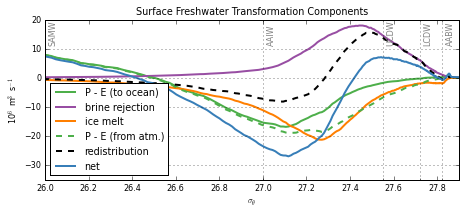

In [159]:
trans_mean = transformation.mean(axis=0)
#trans_mean = transformation_run_matt.mean(axis=0)

mcols = bmap.mpl_colors
plt.rcParams['legend.handlelength'] = 2.5
plt.rcParams['font.size'] = 8

fig = plt.figure(figsize=(6.5,3.0))
ax = fig.add_subplot(111)

idx_mean = np.r_[0,2]



ax.plot(rholevs[1:]-1000, trans_mean[idx_mean].T/1e6, linewidth=2)


# new stuff
ax.plot(rholevs[1:]-1000, (wmt_heat_mean[3]+wmt_heat_mean[4])/1e6,
         '--', color=mcols[0], linewidth=2)
ax.plot(rholevs[1:]-1000, (wmt_salt_mean[4]+wmt_salt_mean[6])/1e6,
         '--', color=mcols[1], linewidth=2)


ax.plot(rholevs[1:]-1000, (trans_mean[idx_mean].sum(axis=0)
                          + wmt_heat_mean[3] + wmt_heat_mean[4]
                          + wmt_salt_mean[4] + wmt_salt_mean[6])/1e6
         , 'k', linewidth=3)
ax.legend(['surf. heat', 'surf. f.w.', 'mixing heat', 'mixing f.w.', 'net'], loc='lower left')
ax.grid()
ax.set_title('Surface Freshwater Transformation Components')
ax.set_xlabel(r'$\sigma_\theta$')
ax.set_ylabel(r'10$^6$ m$^3$ s$^{-1}$')

ax.set_xticks(np.arange(26,28.2,0.2), minor=False);
ax.set_xticks(wmass_names.values(), minor=True);

ax.xaxis.grid(False, which='major')
ax.xaxis.grid(True, which='minor')

for name, dens in wmass_names.iteritems():
    ax.text(dens+0.02, 11, name, color='0.5',
            ha='left', va='bottom', rotation='vertical')

ax.set_xlim([26,27.9])
ax.set_ylim([-35,20])
plt.tight_layout()
plt.savefig('../figures_ice_moc/transformation_sigma0_w_mixing.pdf')

# which fields to plot
fw_transformation = dict()
for ni, k in enumerate(fw_flux_types):
    fw_transformation[k] = trans_mean[ni+2]

fig = plt.figure(figsize=(6.5,3.0))
ax = fig.add_subplot(111)
colors = bmap.mpl_colors[2:]
for nc, k in enumerate(['AO', 'IO_brine', 'IO_melt']):
    tr = fw_transformation[k]
    plt.plot(rholevs[1:]-1000, tr/1e6, linewidth=2, color=colors[nc])
#redist = fw_transformation['IO'] - fw_transformation['AI']
ax.plot(rholevs[1:]-1000, fw_transformation['AI_plus_AO']/1e6, '--',
             linewidth=2, color=colors[0],)
redist = fw_transformation['IO'] - fw_transformation['AI']
ax.plot(rholevs[1:]-1000, redist/1e6, 'k--', linewidth=2)

ax.plot(rholevs[1:]-1000, trans_mean[2]/1e6, color=mcols[1], linewidth=2)
    
    
#plt.plot(rholevs[1:]-1000, trans_mean[1:].T/1e6, linewidth=2)
#plt.legend(['heat', 'fw', 'net'], loc='lower left')
#plt.legend(fw_flux_types, loc='lower left')
ax.legend(['P - E (to ocean)', 'brine rejection', 'ice melt',
            'P - E (from atm.)','redistribution', 'net'], loc='lower_left')
ax.grid()
ax.set_title('Surface Freshwater Transformation Components')
ax.set_xlabel(r'$\sigma_\theta$')
ax.set_ylabel(r'10$^6$ m$^3$ s$^{-1}$')

ax.set_xticks(np.arange(26,28.2,0.2), minor=False);
ax.set_xticks(wmass_names.values(), minor=True);

ax.xaxis.grid(False, which='major')
ax.xaxis.grid(True, which='minor')

for name, dens in wmass_names.iteritems():
    ax.text(dens+0.02, 11, name, color='0.5',
            ha='left', va='bottom', rotation='vertical')

ax.set_xlim([26,27.9])
ax.set_ylim([-35,20])
plt.tight_layout()
plt.savefig('../figures_ice_moc/transformation_fw_sigma0.pdf')



#plt.savefig('../figures_ice_moc/transformation_5day_hires.pdf')

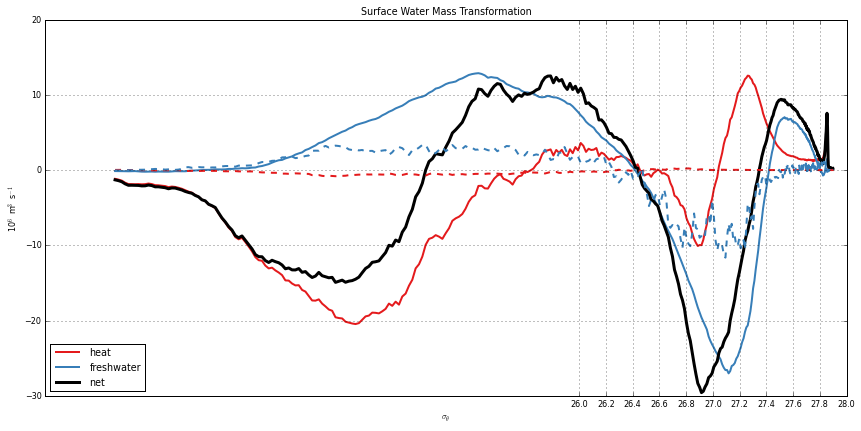

In [28]:
# with wthmass, wsltmass

#plt.figure(figsize=(6.5,3.0))
plt.figure(figsize=(12,6))

idx_mean = np.r_[0,2]

plt.plot(rholevs[1:]-1000, trans_mean[idx_mean].T/1e6, linewidth=2)
plt.plot(rholevs[1:]-1000, trans_mean[idx_mean].sum(axis=0)/1e6, 'k', linewidth=3)
plt.plot(rholevs[1:]-1000, trans_mean[1]/1e6, '--', linewidth=2, color=bmap.mpl_colors[0])
plt.plot(rholevs[1:]-1000, trans_mean[-1]/1e6, '--', linewidth=2, color=bmap.mpl_colors[1])

plt.legend(['heat', 'freshwater', 'net'], loc='lower left')
plt.grid()
plt.title('Surface Water Mass Transformation')
plt.xlabel(r'$\sigma_\theta$')
plt.ylabel(r'10$^6$ m$^3$ s$^{-1}$')
plt.xticks(np.arange(26,28.2,0.2));
#plt.xlim([26,27.9])
plt.ylim([-30,20])
plt.tight_layout()
#plt.savefig('../figures_ice_moc/transformation_5day_sigma0.pdf')

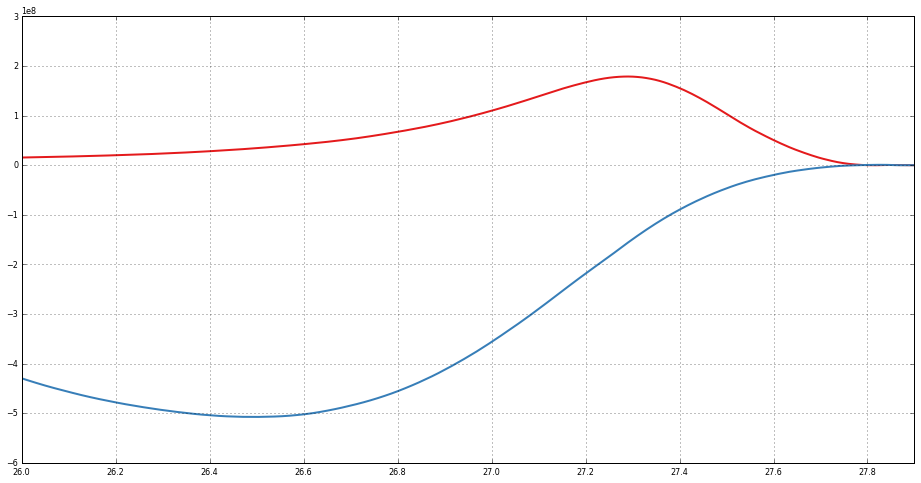

In [38]:
fw_mean = fw_in_dens_coords.mean(axis=0)

drho = np.diff(rholevs)
fw_ice_dens_flux = np.cumsum((drho * (
        fw_mean[fld_idx['IO']] - fw_mean[fld_idx['AI']]
         ))[::-1]
    )[::-1]

fw_atm_dens_flux = np.cumsum((drho * (
        fw_mean[fld_idx['AI_plus_AO']]
         ))[::-1]
    )[::-1]


# units kg / s
m3_per_kg = 1e-3

plt.plot(rholevs[1:]-1000, fw_ice_dens_flux, linewidth=2)
plt.plot(rholevs[1:]-1000, fw_atm_dens_flux, linewidth=2)
plt.xticks(np.arange(26,28.2,0.2));
plt.xlim([26,27.9])
plt.grid()


The two dashed lines sum to give the blue line.

# Temporal Variability #

In [47]:
T = np.array([datetime.datetime(2006,1,1) + datetime.timedelta(days=(n*5)) for n in range(Nt)])
rl = rholevs[1:]-1000

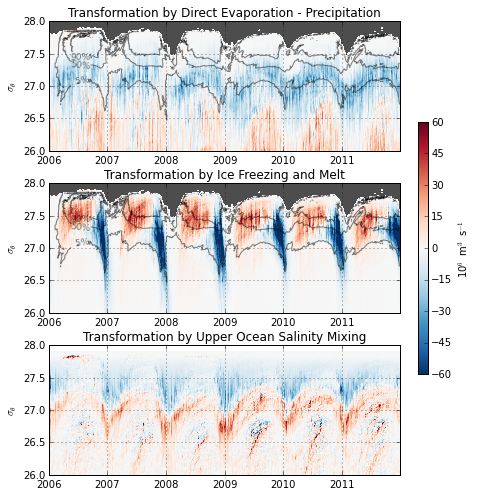

In [135]:
# which fields to plot
fw_transformation = dict()
for ni, k in enumerate(fw_flux_types):
    fw_transformation[k] = transformation[:,ni+2]

fig = plt.figure(figsize=(6.5,7.))

mask = (outcrop_area<1e9)

plt.subplots_adjust(left=0.1, bottom=0.05, right=0.85, top=0.95, hspace=0.25)


### Atm to Ocean ###
plt.subplot(311, axisbg='0.3')
plt.pcolormesh(T, rl, np.ma.masked_array(fw_transformation['AO'], mask).T/1e6,
               cmap='RdBu_r', rasterized=True)
plt.clim([-60,60])
c = plt.contour(T, rl, 100*np.ma.masked_array(ice_conc_rho, mask).T, [5,50,90],
               colors='k', linewidth=0.25, alpha=0.5)
Tlab = T[40].toordinal()
plt.clabel(c, fmt='%2.0f%%', manual=[(Tlab, 27.1),(Tlab, 27.3),(Tlab, 27.5)],
          fontsize=9, inline_spacing=3)
plt.ylim([26.0,28])
plt.ylabel(r'$\sigma_\theta$')
plt.title('Transformation by Direct Evaporation - Precipitation')
plt.grid()

### Ice to Ocean ###
plt.subplot(312, axisbg='0.3')
plt.pcolormesh(T, rl, np.ma.masked_array(fw_transformation['IO'], mask).T/1e6,
               cmap='RdBu_r', rasterized=True)
plt.clim([-60,60])
c = plt.contour(T, rl, 100*np.ma.masked_array(ice_conc_rho, mask).T, [5,50,90],
               colors='k', linewidth=0.25, alpha=0.5)
Tlab = T[40].toordinal()
plt.clabel(c, fmt='%2.0f%%', manual=[(Tlab, 27.1),(Tlab, 27.3),(Tlab, 27.5)],
          fontsize=9, inline_spacing=3)
plt.ylim([26.0,28])
plt.ylabel(r'$\sigma_\theta$')
plt.title('Transformation by Ice Freezing and Melt')
plt.grid()



plt.subplot(313)
pc = plt.pcolormesh(T, rl, np.ma.masked_array(
                                wmt_salt[:,4]+wmt_salt[:,6],
                                0).T/1e6,
                    cmap='RdBu_r', rasterized=True)
plt.clim([-60,60])
plt.ylim([26.0,28])
plt.ylabel(r'$\sigma_\theta$')
plt.title('Transformation by Upper Ocean Salinity Mixing')
plt.grid()

cbax = fig.add_axes([0.89,0.25,0.02,0.5])
cb = plt.colorbar(pc, cax=cbax)
cb.set_label(r'10$^6$ m$^3$ s$^{-1}$')


fig.savefig('../figures_ice_moc/fw_transformation_timeseries.pdf')

In [120]:
T[36].toordinal()

732492

<matplotlib.colorbar.Colorbar instance at 0x7f2540174dd0>

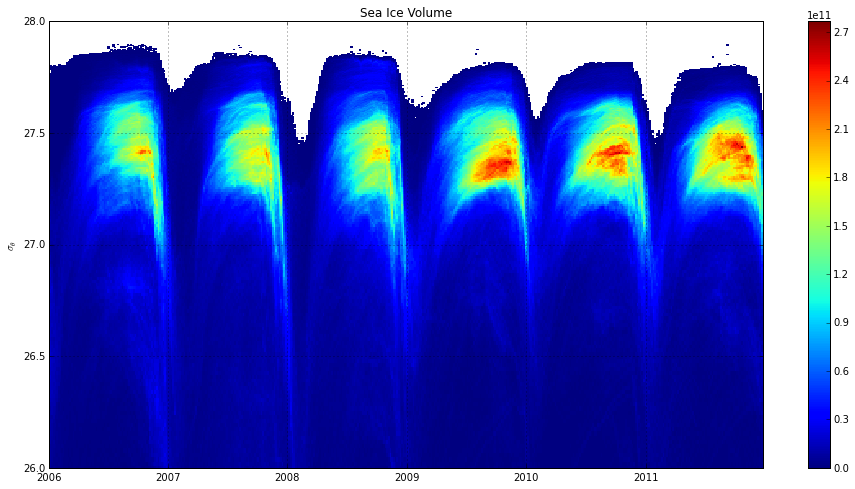

In [142]:
plt.pcolormesh(T, rl, np.ma.masked_array(heff_rho, outcrop_area<1e9).T, rasterized=True)
#plt.clim([-60,60])
plt.ylim([26,28])
plt.ylabel(r'$\sigma_\theta$')
plt.title('Sea Ice Volume')
plt.grid()
plt.colorbar()

In [92]:
m.rac.mean()/1e8

2.0704503627499999

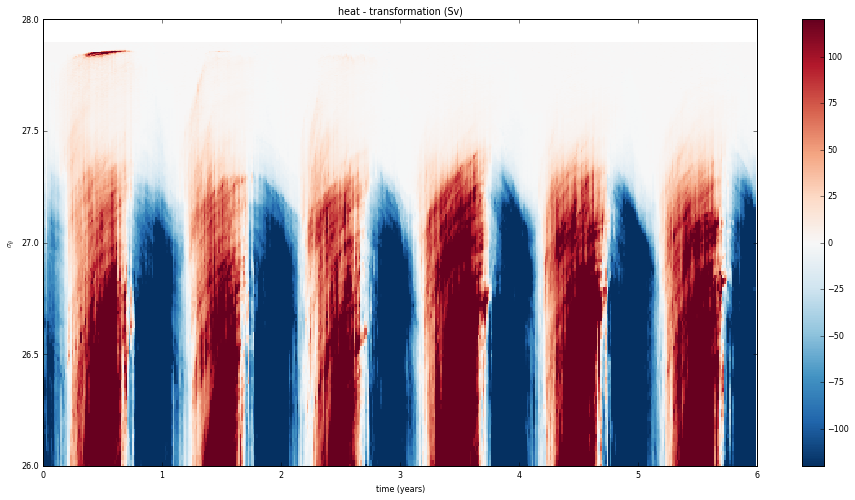

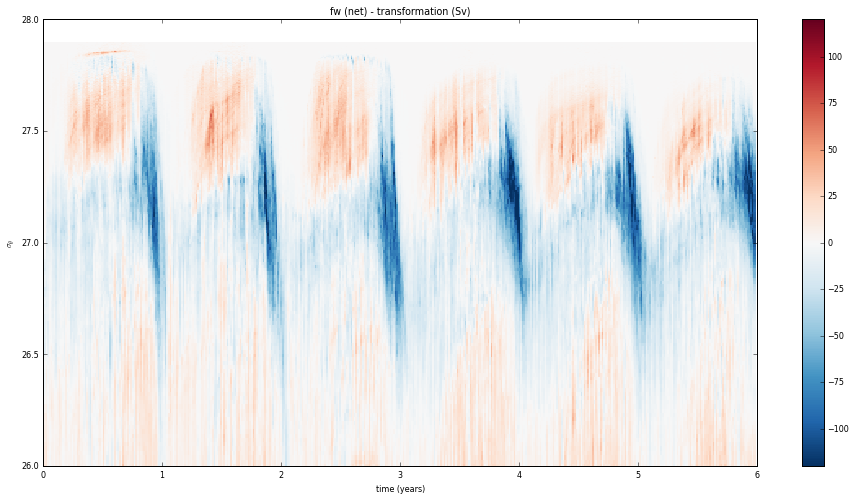

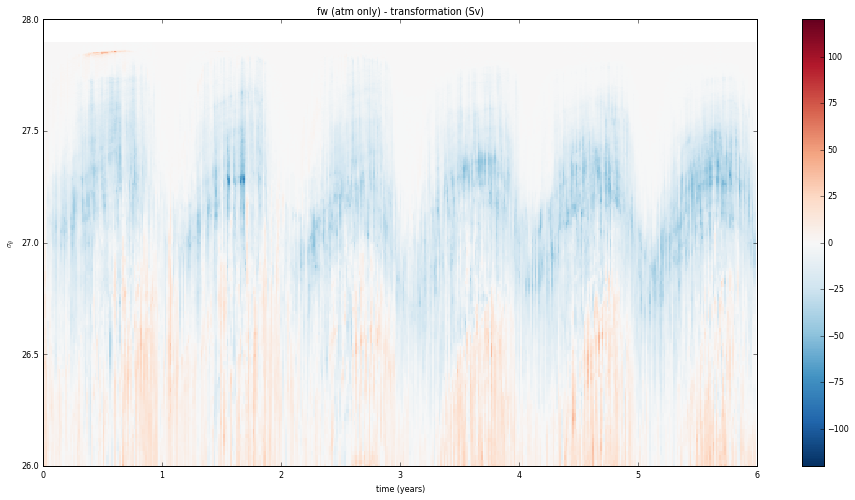

In [67]:
rl = rholevs[1:]-1000
time = np.arange(Nt)*5/365.

for n, tit in enumerate(['heat', 'fw (net)', 'fw (atm only)']):
    plt.figure()
    plt.pcolormesh(time, rl, transformation_monthy[:,n].T / 1e6, cmap='RdBu_r')
    plt.clim([-120,120])
    plt.ylim([26,28])
    plt.ylabel(r'$\sigma_\theta$')
    plt.xlabel('time (years)')
    plt.title(tit + ' - transformation (Sv)')
    plt.colorbar()